In [ ]:
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

<a href="https://colab.research.google.com/github/neryguilherme/thegamelibrary/blob/main/Classifica%C3%A7%C3%A3o_Mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Carregar os dados
banco = pd.read_parquet('/content/games.parquet')

banco

OSError: Corrupt snappy compressed data.

In [ ]:
# Preenchimento de valores faltantes
for col in banco.columns:
    if banco[col].dtype == 'object':
        banco[col] = banco[col].fillna(banco[col].mode()[0])  # Preenche com a moda
    elif pd.api.types.is_numeric_dtype(banco[col]):
        banco[col] = banco[col].fillna(banco[col].median())  # Preenche com a mediana
banco


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Indie,Casual",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120,SUR5,"Apr 1, 2023",0 - 0,0,0,0.00,0,"Innovative Gameplay SUR5 brings a brand new, f...","['English', 'Polish', 'Spanish - Latin America']",...,0,0,0,Katharsis,Katharsis,"Single-player,Multi-player,PvP,Online PvP,Stea...","Free to Play,Indie,Massively Multiplayer,Strat...","Indie,Casual",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71712,2125160,Prison Life 2,"Mar 30, 2023",0 - 20000,6,0,10.79,0,Core Features Real players only! All Guards an...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,AO Games,AO Games,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Casual,Indie,RPG,Simulation,Strategy","First-Person,Detective,Social Deduction,Multip...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71713,2318860,Architecture Zeitgeist,"Mar 27, 2023",0 - 20000,0,0,5.99,0,Architecture Zeitgeist is a game created with ...,"['English', 'Japanese', 'Portuguese - Brazil',...",...,0,0,0,Matheus Rudo,Rudo Studios,Single-player,"Casual,Simulation,Early Access","Casual,Simulation,Puzzle,Exploration,Immersive...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71714,2180330,Girl's Way to Survive 2: Bloody Museum,"Apr 2, 2023",0 - 0,0,0,2.39,0,"Development progress: prologue map (finished),...",['Simplified Chinese'],...,0,0,0,绅士游戏工坊,绅士游戏工坊,Single-player,"Action,Casual,Indie,RPG,Early Access","Indie,Casual",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [ ]:
# prompt: aplique o label encoder nos atributos

# Aplicar Label Encoding aos atributos categóricos
label_encoders = {}
x_column = banco.copy()
for column in x_column.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    x_column[column] = le.fit_transform(x_column[column])
    label_encoders[column] = le
x_column

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,23057,3607,1,0,0,19.99,0,23392,9273,...,0,0,0,26237,22614,4293,1419,31908,34772,50347
1,655370,62118,3488,1,0,0,0.99,0,49461,3664,...,0,0,0,29606,32773,4574,682,29681,57021,11773
2,1732930,30303,3198,1,0,0,4.99,0,32483,7444,...,0,0,0,5860,5041,924,355,30826,26032,46442
3,1355720,26378,1874,1,0,0,5.99,0,25331,3516,...,0,0,0,24890,21455,976,874,124,13049,39829
4,1139950,62950,1294,1,0,0,0.00,0,5634,9098,...,0,0,0,36483,31424,4437,1013,30395,5419,28277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120,49224,14,0,0,0,0.00,0,30669,7281,...,0,0,0,18484,15872,3508,1581,30826,38113,63073
71712,2125160,44325,2664,1,6,0,10.79,0,14619,2512,...,0,0,0,778,723,2458,1378,25759,37196,65885
71713,2318860,3794,2620,1,0,0,5.99,0,8482,6814,...,0,0,0,21735,25501,924,1468,20303,41817,66064
71714,2180330,23825,134,0,0,0,2.39,0,16805,9583,...,0,0,0,42313,36565,924,514,30826,38663,62976


In [ ]:
X = x_column.drop(columns=['Genres'])
X.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [ ]:
# Escalonar os dados numéricos
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['number']).columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X

,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,...,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Tags,Screenshots,Movies
0,1.248325,-0.447085,-0.024282,-0.145418,1.153087,-0.04121,-0.550053,0.568330,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,0.451959,0.474674,0.820258,0.432102,-0.042294,0.935097
1,1.149448,-0.447085,-0.024282,-0.145418,-0.562958,-0.04121,0.780267,-1.664751,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,0.725161,1.419140,0.976020,0.266444,1.048669,-1.141058
2,0.908487,-0.447085,-0.024282,-0.145418,-0.201685,-0.04121,-0.086133,-0.159840,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,-1.200474,-1.159060,-1.047220,0.351616,-0.470853,0.724920
3,-0.191622,-0.447085,-0.024282,-0.145418,-0.111367,-0.04121,-0.451105,-1.723674,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,0.342726,0.366923,-1.018395,-1.932185,-1.107465,0.368991
4,-0.673543,-0.447085,-0.024282,-0.145418,-0.652373,-0.04121,-1.456257,0.498658,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,1.282838,1.293725,0.900079,0.319556,-1.481597,-0.252769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,-1.737093,-0.803532,-0.024282,-0.145418,-0.652373,-0.04121,-0.178703,-0.224734,-0.567180,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,-0.176756,-0.152119,0.385123,0.351616,0.121529,1.620044
71712,0.464788,-0.447085,-0.023247,-0.145418,0.322160,-0.04121,-0.997746,-2.123391,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,-1.612589,-1.560498,-0.196905,-0.025298,0.076565,1.771393
71713,0.428228,-0.447085,-0.024282,-0.145418,-0.111367,-0.04121,-1.310922,-0.410659,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,0.086878,0.743074,-1.047220,-0.431148,0.303152,1.781028
71714,-1.637385,-0.803532,-0.024282,-0.145418,-0.436513,-0.04121,-0.886193,0.691749,0.537784,0.260518,...,-0.09687,-0.057575,-0.065114,-0.056889,1.755610,1.771676,-1.047220,0.351616,0.148498,1.614823


In [ ]:
X.columns

Index(['Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price',
       'DLC count', 'About the game', 'Supported languages',
       'Full audio languages', 'Reviews', 'Header image', 'Website',
       'Support url', 'Support email', 'Windows', 'Mac', 'Linux',
       'Metacritic score', 'Metacritic url', 'User score', 'Positive',
       'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Notes',
       'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [ ]:
#y = le.fit_transform(name_column)
k = x_column['Genres'] #Definindo k para a coluna Genres
k = le.fit_transform(k)
k

array([1419,  682,  355, ..., 1468,  514, 1340])

In [ ]:
# prompt: Faça a variancia e remova os atributos inuteis e pront as colunas inuteis

# Calcular a variância de cada coluna
variances = x_column.var()

# Definir um limiar de variância (ex: 0.01, que representa 1%)
threshold = 0.01

# Identificar colunas com variância abaixo do limiar
low_variance_cols = variances[variances < threshold].index.tolist()

x_column


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,23057,3607,1,0,0,19.99,0,23392,9273,...,0,0,0,26237,22614,4293,1419,31908,34772,50347
1,655370,62118,3488,1,0,0,0.99,0,49461,3664,...,0,0,0,29606,32773,4574,682,29681,57021,11773
2,1732930,30303,3198,1,0,0,4.99,0,32483,7444,...,0,0,0,5860,5041,924,355,30826,26032,46442
3,1355720,26378,1874,1,0,0,5.99,0,25331,3516,...,0,0,0,24890,21455,976,874,124,13049,39829
4,1139950,62950,1294,1,0,0,0.00,0,5634,9098,...,0,0,0,36483,31424,4437,1013,30395,5419,28277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120,49224,14,0,0,0,0.00,0,30669,7281,...,0,0,0,18484,15872,3508,1581,30826,38113,63073
71712,2125160,44325,2664,1,6,0,10.79,0,14619,2512,...,0,0,0,778,723,2458,1378,25759,37196,65885
71713,2318860,3794,2620,1,0,0,5.99,0,8482,6814,...,0,0,0,21735,25501,924,1468,20303,41817,66064
71714,2180330,23825,134,0,0,0,2.39,0,16805,9583,...,0,0,0,42313,36565,924,514,30826,38663,62976


In [ ]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, k, test_size=0.3)

# Criar e treinar o modelo MLP
model = MLPClassifier(max_iter=200, verbose=True, tol=0.0000100,solver = 'adam',hidden_layer_sizes = (50,50),activation = 'relu',random_state=42)
model.fit(X_train, y_train)


# Fazer previsões e avaliar o modelo
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
#metricas do teste
accuracy_model = accuracy_score(y_test, y_pred)
precision_score_model = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_score_model = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_score_model = f1_score(y_test, y_pred, average='weighted', zero_division=0)
#metricas do treino
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_score_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
recall_score_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
f1_score_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)

#
print(classification_report(y_test, y_pred, zero_division=0))
print("-" * 50)
print(f"Acurácia no conjunto de treinamento: {accuracy_train}")
print(f"Precisão no conjunto de treinamento: {precision_score_train}")
print(f"Recall no conjunto de treinamento: {recall_score_train}")
print(f"F1-score no conjunto de treinamento: {f1_score_train}")
print("-" * 50)
print(f"Acurácia no conjunto de teste: {accuracy_model}")
print(f"Precisão no conjunto de teste: {precision_score_model}")
print(f"Recall no conjunto de teste: {recall_score_model}")
print(f"F1-score no conjunto de teste: {f1_score_model}")

Iteration 1, loss = 5.31384477
Iteration 2, loss = 4.67104828
Iteration 3, loss = 4.53100656
Iteration 4, loss = 4.43599138
Iteration 5, loss = 4.35886534
Iteration 6, loss = 4.29246861
Iteration 7, loss = 4.23844497
Iteration 8, loss = 4.19126099
Iteration 9, loss = 4.14781325
Iteration 10, loss = 4.10968617
Iteration 11, loss = 4.07610312
Iteration 12, loss = 4.04323828
Iteration 13, loss = 4.01116919
Iteration 14, loss = 3.98194828
Iteration 15, loss = 3.95675861
Iteration 16, loss = 3.93046822
Iteration 17, loss = 3.90511388
Iteration 18, loss = 3.87822032
Iteration 19, loss = 3.85471689
Iteration 20, loss = 3.83279635
Iteration 21, loss = 3.81748844
Iteration 22, loss = 3.79344181
Iteration 23, loss = 3.78007799
Iteration 24, loss = 3.75922271
Iteration 25, loss = 3.74061731
Iteration 26, loss = 3.72599311
Iteration 27, loss = 3.70911213
Iteration 28, loss = 3.69738087
Iteration 29, loss = 3.68424790
Iteration 30, loss = 3.67510604
Iteration 31, loss = 3.66570210
Iteration 32, los

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.25      0.15      0.19       609
           7       0.31      0.12      0.17       281
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        33
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          19       0.00    

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

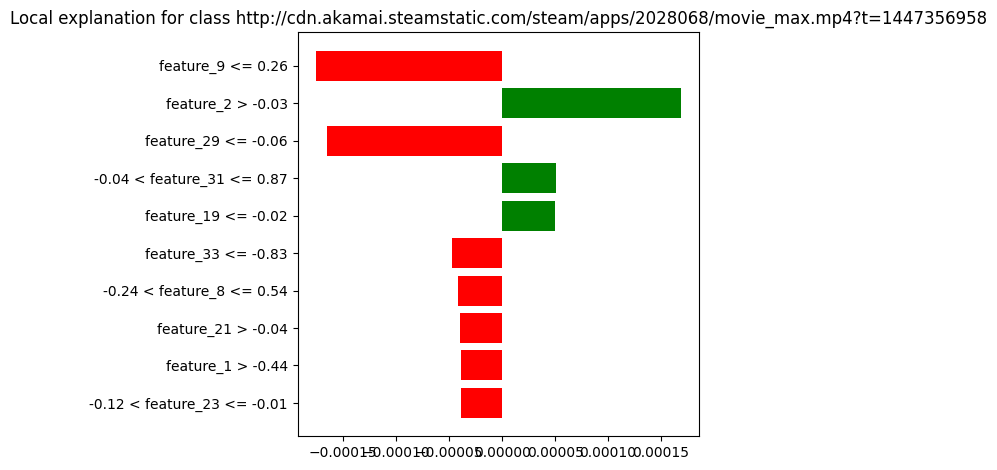


Feature Importances:
feature_9 <= 0.26: -0.0002
feature_2 > -0.03: 0.0002
feature_29 <= -0.06: -0.0002
-0.04 < feature_31 <= 0.87: 0.0001
feature_19 <= -0.02: 0.0000
feature_33 <= -0.83: -0.0000
-0.24 < feature_8 <= 0.54: -0.0000
feature_21 > -0.04: -0.0000
feature_1 > -0.44: -0.0000
-0.12 < feature_23 <= -0.01: -0.0000


In [ ]:
# Create LIME explainer
class_names = le.classes_
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
explainer = lime.lime_tabular.LimeTabularExplainer(
    scaler.fit_transform(X_train),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Get explanation for a test instance
instance_idx = 0
exp = explainer.explain_instance(
    scaler.transform(X_test)[instance_idx],
    model.predict_proba,
    num_features=10
)

# Plot explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

# Print feature importance details
print("\nFeature Importances:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

In [ ]:
# prompt: use lime para analisar quais classes do modelo tem maior influencia no modelo

import lime
import lime.lime_tabular

# Crie um explainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=le.classes_.tolist(), # Use as classes do LabelEncoder
    mode="classification"
)

# Selecione um exemplo para explicar (índice 0 do conjunto de teste, por exemplo)
i = 0
example = X_test.iloc[i]

# Gere a explicação para o exemplo
exp = explainer.explain_instance(example.values, model.predict_proba, num_features=10)

# Imprima as features mais influentes para cada classe
print(f"Explicação para o exemplo {i}:")
print(le.classes_.tolist())
''' for class_index, class_ in enumerate(le.classes_):  # Itera pelas classes e seus índices
    print(f"\nClasse: {class_}")
    # Verifique se a chave existe no dicionário local_exp
    if class_index in exp.local_exp:
        local_exp = exp.as_list(label=class_index)
        for feature, weight in local_exp:
            print(f"  {feature}: {weight}")
    else:
        print(f"Aviso: Explicação não encontrada para a classe '{class_}' (índice {class_index})") '''


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Explicação para o exemplo 0:
[-1.739789340463565, -1.7380080365278887, -1.7362267325922127, -1.7344454286565365, -1.7326641247208603, -1.7308828207851843, -1.729101516849508, -1.7273202129138319, -1.7255389089781556, -1.7237576050424797, -1.7219763011068034, -1.7201949971711272, -1.7184136932354512, -1.716632389299775, -1.7148510853640988, -1.7130697814284228, -1.7112884774927466, -1.7095071735570704, -1.7077258696213944, -1.7059445656857182, -1.704163261750042, -1.7023819578143657, -1.7006006538786897, -1.6988193499430135, -1.6970380460073373, -1.6952567420716613, -1.6934754381359851, -1.691694134200309, -1.689912830264633, -1.6881315263289567, -1.6863502223932805, -1.6845689184576045, -1.6827876145219283, -1.681006310586252, -1.6792250066505758, -1.6774437027148998, -1.6756623987792236, -1.6738810948435474, -1.6720997909078714, -1.6703184869721952, -1.668537183036519, -1.666755879100843, -1.6649745751651668, -1.6631932712294906, -1.6614119672938146, -1.6596306633581384, -1.6578493594

' for class_index, class_ in enumerate(le.classes_):  # Itera pelas classes e seus índices\n    print(f"\nClasse: {class_}")\n    # Verifique se a chave existe no dicionário local_exp\n    if class_index in exp.local_exp: \n        local_exp = exp.as_list(label=class_index)\n        for feature, weight in local_exp:\n            print(f"  {feature}: {weight}")\n    else:\n        print(f"Aviso: Explicação não encontrada para a classe \'{class_}\' (índice {class_index})") '